Класифікація датсету
https://archive.ics.uci.edu/ml/datasets/glass+identification
Задача - усунення дисбалансу і перевірка впливу на точність моделі

*   первинний аналіз даних (відстуність пропусків, наявність категоріальних фіч, duplicated, Nan)
*   фича інжиніринг (побудувати 1-2 нові фічі)
*   Убрать кореляцію в фічах
*   поділ датасету на train, validate, test (+ random_state)

*   GridSearchCV
*   Scaling

*   тренування базової моделі із дефолтними гіперпараметрами (кожну модель)
*   підбір гіперпараметрів (кожну модель)
*   побудувати модель різними способами
*   Metrics: classification_report, ROC-AUC, precision_recall_curve ...
*   оцінка результатів (порівняння всіх на тестовій частині, описати яка краще)
*  Додати ще один Балансер
*  Додати ще один скалер


## INIT BLOCK

### Import Requirements

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from matplotlib.axes import Axes
from matplotlib.container import BarContainer
from pandas.core.arrays.sparse.array import NaT
from pandas.core.groupby import DataFrameGroupBy
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, Lasso, LogisticRegression
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report, precision_recall_curve,
                             precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, KMeansSMOTE, SMOTENC, SVMSMOTE


### Init

In [ ]:
RANDOM_STATE: int = 1729


def mount_google_drive() -> bool | None:
    """
    Function to mount Google Drive.
    :return: True if mounting is successful, None otherwise.
    """
    try:
        from google.colab.drive import mount

        mount(mountpoint="/content/drive")
        return True

    except Exception as error:
        print(f"Error while mounting Google Drive: {error}")
        raise


def get_data_frame(dataset_path: str, *args, sep: str = ",", **kwargs) -> pd.DataFrame | None:
    """
    Function to convert the dataset into a pd.DataFrame.
    :param sep: Separator for csv data, default - ",".
    :param dataset_path: Path or URL of the dataset.
    :return: pd.DataFrame containing the dataset, or None if errors occur.
    """
    try:
        return pd.read_csv(filepath_or_buffer=dataset_path, sep=sep, **kwargs)

    except Exception as error:
        print(f"Error while converting dataset to NumPy array: {error}")
        raise


def main(dataset_path: str, *args, **kwargs) -> pd.DataFrame | None:
    """
    Main function to start the app.
    :return: pd.DataFrame containing the dataset, or None if errors occur.
    """
    if mount_google_drive():
        import os

        if os.path.exists(path=dataset_path):
            return get_data_frame(dataset_path=dataset_path, *args, **kwargs)

        else:
            print("Dataset path doesn't exists.")
            raise FileNotFoundError


if __name__ == "__main__":
    glass_dataframe: pd.DataFrame | None = main(dataset_path="/content/drive/MyDrive/Hillel/Machine_Learning_Course/HW7/glass+identification/glass.data", header=None)

    if isinstance(glass_dataframe, pd.DataFrame):
        working_dataframe: pd.DataFrame = glass_dataframe.copy()

        target_column_name: str = "Type_Of_Glass"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data analysis, clining and optomization

### Перевіряємо на дублікати

In [ ]:
print(f"{'Є дублікати, потрібна обробка датасету.' if working_dataframe.duplicated().sum() else 'Дублікатів немає.'}", end="\n\n")

Дублікатів немає.



### Обробка відсутніх відсутніх значеннь

In [ ]:
print(f"{'Є пропущені значення, потрібна обробка датасету.' if working_dataframe.isna().any().any() else 'Пропущених значень немає.'}", end="\n\n")
working_dataframe.info()

Пропущених значень немає.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       214 non-null    int64  
 1   1       214 non-null    float64
 2   2       214 non-null    float64
 3   3       214 non-null    float64
 4   4       214 non-null    float64
 5   5       214 non-null    float64
 6   6       214 non-null    float64
 7   7       214 non-null    float64
 8   8       214 non-null    float64
 9   9       214 non-null    float64
 10  10      214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB


### Видаляємо зайву колонку з індексом (знаю що можна індекс передати в read_csv(), але мені так більше подобається =) )

In [ ]:
working_dataframe: pd.DataFrame = working_dataframe.drop(columns=0)

working_dataframe.info()
working_dataframe.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       214 non-null    float64
 1   2       214 non-null    float64
 2   3       214 non-null    float64
 3   4       214 non-null    float64
 4   5       214 non-null    float64
 5   6       214 non-null    float64
 6   7       214 non-null    float64
 7   8       214 non-null    float64
 8   9       214 non-null    float64
 9   10      214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


,1,2,3,4,5,6,7,8,9,10
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1


### Додаємо хедери

In [ ]:
headers: tuple = ("RI_RefractiveIndex", "Na_Sodium", "Mg_Magnesium", "Al_Aluminum", "Si_Silicon", "K_Potassium", "Ca_Calcium", "Ba_Barium", "Fe_Iron", "Type_Of_Glass")
working_dataframe.columns = headers

working_dataframe.info()
working_dataframe.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RI_RefractiveIndex  214 non-null    float64
 1   Na_Sodium           214 non-null    float64
 2   Mg_Magnesium        214 non-null    float64
 3   Al_Aluminum         214 non-null    float64
 4   Si_Silicon          214 non-null    float64
 5   K_Potassium         214 non-null    float64
 6   Ca_Calcium          214 non-null    float64
 7   Ba_Barium           214 non-null    float64
 8   Fe_Iron             214 non-null    float64
 9   Type_Of_Glass       214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


,RI_RefractiveIndex,Na_Sodium,Mg_Magnesium,Al_Aluminum,Si_Silicon,K_Potassium,Ca_Calcium,Ba_Barium,Fe_Iron,Type_Of_Glass
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


### Міняємо типи даних для пришвидшення та економії памʼяті

In [ ]:
working_dataframe[target_column_name]: pd.DataFrame = working_dataframe[target_column_name].astype(np.byte)

working_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RI_RefractiveIndex  214 non-null    float64
 1   Na_Sodium           214 non-null    float64
 2   Mg_Magnesium        214 non-null    float64
 3   Al_Aluminum         214 non-null    float64
 4   Si_Silicon          214 non-null    float64
 5   K_Potassium         214 non-null    float64
 6   Ca_Calcium          214 non-null    float64
 7   Ba_Barium           214 non-null    float64
 8   Fe_Iron             214 non-null    float64
 9   Type_Of_Glass       214 non-null    int8   
dtypes: float64(9), int8(1)
memory usage: 15.4 KB


### Генеруємо статистику

In [ ]:
working_dataframe.describe(include="all", percentiles=[.25, .5, .75])

,RI_RefractiveIndex,Na_Sodium,Mg_Magnesium,Al_Aluminum,Si_Silicon,K_Potassium,Ca_Calcium,Ba_Barium,Fe_Iron,Type_Of_Glass
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


## Feature Engineering

### Візуалізація даних

<Axes: >

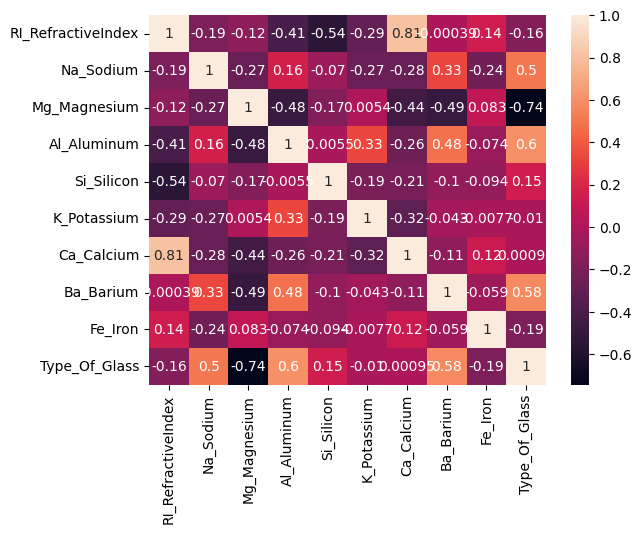

In [ ]:
working_dataframe_corr_matrix = working_dataframe.corr()
sns.heatmap(data=working_dataframe_corr_matrix, annot=True)

1. Бачимо, що "Mg_Magnesium" достатньо сильно корелює з таргетом, можливо це допоможе покращити класифікацію, якщо буде необхідність.
2. Також можна відмітити, що значної кореляціїї фічів крім "RI_RefractiveIndex" та "Ca_Calcium" немає (розглянемо їх нижче), тому фічі залишаємо в такому вигляді.

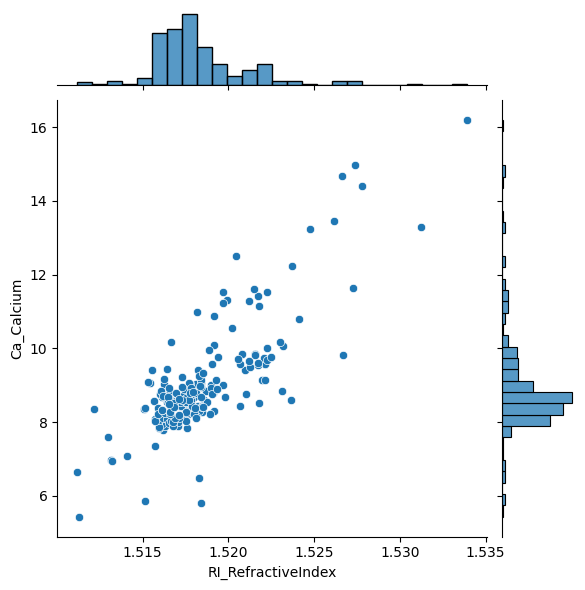

In [ ]:
sns.jointplot(x="RI_RefractiveIndex", y="Ca_Calcium", data=working_dataframe, kind="scatter", dropna=True)

Є щось схоже на кореляцію між RI_RefractiveIndex та Ca_Calcium, але через те, що даних замало, важко точно сказати, тому залишаємо як є.

### Робимо фічі за допомогою TSNE

<Axes: >

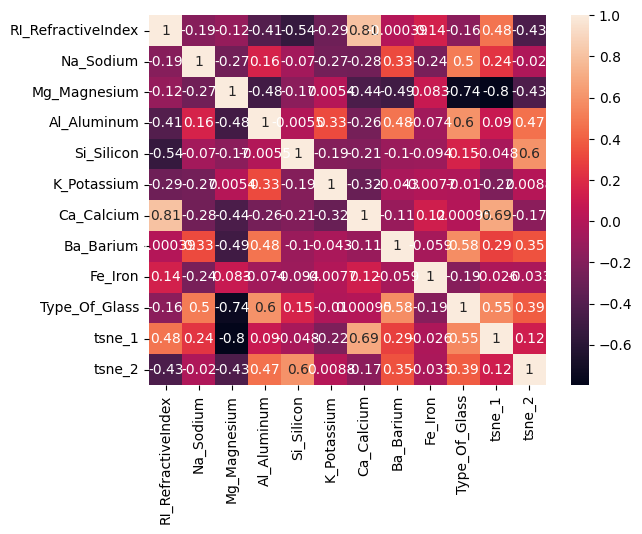

In [ ]:
x_tsne = working_dataframe.copy().drop(target_column_name, axis=1)
x_embedded = TSNE(n_components=2, learning_rate="auto", init="pca", method="exact", perplexity=7, random_state=RANDOM_STATE).fit_transform(X=x_tsne)
working_dataframe[["tsne_1", "tsne_2"]] = x_embedded

working_dataframe_tsne_corr_matrix = working_dataframe.corr()
sns.heatmap(data=working_dataframe_tsne_corr_matrix, annot=True)

Висновок робити сенсу немає, тому що TSNE фічі створюються завжди різні, нівіть з параметром "random_state", тому і вплив на дані мають завжди різний. Але іноді кореляція з таргетом може доходити до 0.6, що може значно вплинути на здатність моделі до правильної класифікації.

## Preparing data for training

### Розбиваємо датасет на фічі та таргет

In [ ]:
x_features: pd.DataFrame = working_dataframe.copy().drop(target_column_name, axis=1)
y_target: pd.Series = working_dataframe[target_column_name]

### Масштабування фічів

In [ ]:
# scaler: StandardScaler = StandardScaler().fit(X=x_features)
scaler: StandardScaler = PowerTransformer().fit(X=x_features)  # best result 87 both of Random Fores
# scaler: StandardScaler = RobustScaler().fit(X=x_features) # best result 83 both of Random Fores Grid and GB default

x_scaled: np.ndarray = scaler.transform(X=x_features)

### Розбиваємо дані на тренувальну, валідаційну та тестову частину

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_target, test_size=0.33, random_state=RANDOM_STATE, stratify=y_target)
x_validate, x_test, y_validate, y_test = train_test_split(x_test, y_test, test_size=0.33, random_state=RANDOM_STATE, stratify=y_test)

print(type(y_train))
print(x_train.shape)
print(x_validate.shape)
print(x_test.shape)

<class 'pandas.core.series.Series'>
(143, 11)
(47, 11)
(24, 11)


### Перевіряємо розподіл классів

In [ ]:
print(f"Загальний таргет:\n{working_dataframe[target_column_name].value_counts()}", end="\n\n")
print(f"Тренувальний таргет:\n{y_train.value_counts()}")

Загальний таргет:
2    76
1    70
7    29
3    17
5    13
6     9
Name: Type_Of_Glass, dtype: int64

Тренувальний таргет:
2    51
1    47
7    19
3    11
5     9
6     6
Name: Type_Of_Glass, dtype: int64


*Бачімо, що необхідне балансування классів. Так як екземплярів дуже мало, "Undersampling" в данному випадку не підходить. Будемо наповнювати датасет данними через "Oversampling"*

### Балансування классів

In [ ]:
balancer = BorderlineSMOTE(random_state=RANDOM_STATE, k_neighbors=5, sampling_strategy="auto")  # кращій результат 0.79 GB defaul та RForest Grid
# balancer = KMeansSMOTE(random_state=RANDOM_STATE, k_neighbors=2, sampling_strategy="auto")  #  кращій результат 0.79 model GBG
# balancer = SVMSMOTE(random_state=RANDOM_STATE, k_neighbors=5, sampling_strategy="auto") #  кращій результат 79 RForest def
x_resampled, y_resampled = balancer.fit_resample(X=x_train, y=y_train)

print(x_resampled.shape)
print(f"Тренувальний таргет:\n{y_resampled.value_counts()}")

(274, 11)
Тренувальний таргет:
2    51
1    51
5    51
3    51
6    51
7    19
Name: Type_Of_Glass, dtype: int64


# FIT PREDICT

### Functions for fit models, make predict and generate metrics

In [ ]:
def print_model_name(name: str) -> None:
    print("'" * 60)
    print(f"MODEL: {name}")

In [ ]:
def value_results_main(model, predict, y_test):
    accuracy = accuracy_score(y_true=y_test, y_pred=predict)
    precision = precision_score(y_true=y_test, y_pred=predict, average="micro")
    recall = recall_score(y_true=y_test, y_pred=predict, average="micro")
    f1 = f1_score(y_true=y_test, y_pred=predict, average="micro")

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    print("'" * 60)

In [ ]:
def value_results(model, name:str, predict, y_test):
    print_model_name(name=name)
    value_results_main(model=model, predict=predict, y_test=y_test)

In [ ]:
def train_model(model_class, name: str, grid_params=None):
    print_model_name(name=name)

    if grid_params:
        model: GridSearchCV = GridSearchCV(estimator=model_class, param_grid=grid_params).fit(X=x_resampled, y=y_resampled)

        print("Best params: ", model.best_params_)
        print("Best score: ", model.best_score_)

    else:
        model = model_class().fit(X=x_resampled, y=y_resampled)

    y_pred = model.predict(X=x_validate)

    print(f"Classification report:\n{classification_report(y_true=y_validate, y_pred=y_pred)}")

    value_results_main(model=model, predict=y_pred, y_test=y_validate)

    return model


### Тренуємо моделі

In [ ]:
## KNeighborsClassifier() with default hyperparams
model_kn_classifier: KNeighborsClassifier = train_model(model_class=KNeighborsClassifier, name="KNeighborsClassifier with default hyperparameters")

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: KNeighborsClassifier with default hyperparameters
Classification report:
              precision    recall  f1-score   support

           1       0.60      0.40      0.48        15
           2       0.70      0.44      0.54        16
           3       0.23      0.75      0.35         4
           5       0.43      1.00      0.60         3
           6       1.00      1.00      1.00         2
           7       1.00      0.71      0.83         7

    accuracy                           0.55        47
   macro avg       0.66      0.72      0.63        47
weighted avg       0.67      0.55      0.57        47

Accuracy: 0.5531914893617021
Precision: 0.5531914893617021
Recall: 0.5531914893617021
F1 Score: 0.5531914893617021
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


In [ ]:
## GradientBoostingClassifier() with default hyperparams
model_gboost_classifier: GradientBoostingClassifier = train_model(model_class=GradientBoostingClassifier, name="GradientBoostingClassifier with default hyperparameters")

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: GradientBoostingClassifier with default hyperparameters
Classification report:
              precision    recall  f1-score   support

           1       0.75      0.60      0.67        15
           2       0.65      0.94      0.77        16
           3       0.40      0.50      0.44         4
           5       0.50      0.33      0.40         3
           6       0.00      0.00      0.00         2
           7       1.00      0.71      0.83         7

    accuracy                           0.68        47
   macro avg       0.55      0.51      0.52        47
weighted avg       0.68      0.68      0.66        47

Accuracy: 0.6808510638297872
Precision: 0.6808510638297872
Recall: 0.6808510638297872
F1 Score: 0.6808510638297872
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## RandomForestClassifier() with default hyperparams
model_random_forest_classifier: RandomForestClassifier = train_model(model_class=RandomForestClassifier, name="RandomForestClassifier with default hyperparameters")

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: RandomForestClassifier with default hyperparameters
Classification report:
              precision    recall  f1-score   support

           1       0.71      0.67      0.69        15
           2       0.81      0.81      0.81        16
           3       0.29      0.50      0.36         4
           5       0.75      1.00      0.86         3
           6       1.00      0.50      0.67         2
           7       1.00      0.71      0.83         7

    accuracy                           0.72        47
   macro avg       0.76      0.70      0.70        47
weighted avg       0.77      0.72      0.73        47

Accuracy: 0.723404255319149
Precision: 0.723404255319149
Recall: 0.723404255319149
F1 Score: 0.723404255319149
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


In [ ]:
## KNeighborsClassifier() з підбіром параметрів через GridSearchCV
grid_kn_clasifier_params = {
    "n_neighbors": list(range(4, 6)),
    "weights": ["uniform", "distance"],  # best - uniform
    # "weights": ["uniform",],
    "metric": ["euclidean", "manhattan", "cityblock", "l1", "l2", "cosine", "haversine", "nan_euclidean"], # best - euclidean
    # "metric": ["euclidean",],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],  # best - ball_tree
    # "algorithm": ["ball_tree",],
    # "leaf_size": list(range(20,41)), # best 25
    "leaf_size": [23, 24, 25, 26],
    "p": [1, 2]
}
model_kn_classifier_grid = train_model(model_class=KNeighborsClassifier(), name="KNeighborsClassifier with Grid hyperparameters", grid_params=grid_kn_clasifier_params)

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: KNeighborsClassifier with Grid hyperparameters


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 824, in kneighbors
    results = ArgKmin.com

Best params:  {'algorithm': 'auto', 'leaf_size': 23, 'metric': 'manhattan', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best score:  0.8282828282828284
Classification report:
              precision    recall  f1-score   support

           1       0.62      0.53      0.57        15
           2       0.80      0.50      0.62        16
           3       0.20      0.50      0.29         4
           5       0.43      1.00      0.60         3
           6       1.00      1.00      1.00         2
           7       1.00      0.71      0.83         7

    accuracy                           0.60        47
   macro avg       0.67      0.71      0.65        47
weighted avg       0.70      0.60      0.62        47

Accuracy: 0.5957446808510638
Precision: 0.5957446808510638
Recall: 0.5957446808510638
F1 Score: 0.5957446808510638
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1120 fits failed out of a total of 5120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 215, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 646, in _fit
    self._tree = BallTree(
  File "sklearn/neighbors/_binary_tree.pxi", line 853, in 

In [ ]:
## GradientBoostingClassifier() з підбіром параметрів через GridSearchCV
grid_g_boost_clasifier_params = {
    # "loss": ["log_loss", "exponential"],
    "loss": ["log_loss"],
    "learning_rate": [0.5],
    "n_estimators": [97],
    "subsample": [0.9],
    # "criterion": ["friedman_mse", "squared_error"],
    "criterion": ["friedman_mse"],
    "min_samples_split": [3,],
    "min_samples_leaf": [1,],
    "min_weight_fraction_leaf": [0.2],  # 0.0, 0.1, 0.2, 0.3, 0.4, 0.5
    "max_depth": [2],
    "min_impurity_decrease": [0.0],  # > 0
    "max_features": ["log2"],
    "verbose": [1],
    "warm_start": [True],#only
    "n_iter_no_change": [None], # > 1
}
model_gboost_classifier_grid = train_model(model_class=GradientBoostingClassifier(), name="GradientBoostingClassifier with Grid hyperparameters", grid_params=grid_g_boost_clasifier_params)

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: GradientBoostingClassifier with Grid hyperparameters
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1740           0.5284            0.88s
         2           0.9349           0.1733            1.51s
         3           0.7867           0.0397            1.34s
         4           0.6608           0.1397            1.20s
         5           0.5519           0.0651            1.10s
         6           0.4681          -0.0107            1.02s
         7           0.3996           0.0107            0.94s
         8           0.3838          -0.0090            0.88s
         9           0.3446           0.0583            0.83s
        10           0.2996          -0.0187            0.79s
        20           0.1505          -0.0045            0.57s
        30           0.0846          -0.0060            0.46s
        40           0.0530          -0.0051            0.38s
        50

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## RandomForestClassifier() з підбіром параметрів через GridSearchCV
grid_g_boost_clasifier_params = {
        "n_estimators": [70,],
        # "criterion": ["gini", "entropy", "log_loss"],
        "criterion": ["entropy",],
        # "max_features": ["sqrt", "log2", None],
        "max_features": ["log2"],
        # "bootstrap": [True, False],
        "bootstrap": [True],
        # "oob_score": [True, False],
        "oob_score": [True],
        "warm_start": [False],
        # "warm_start": [True, False],
        "class_weight": ["balanced_subsample"],
        # "class_weight": ["balanced", "balanced_subsample"],
}
model_random_forest_classifier_grid = train_model(model_class=RandomForestClassifier(), name="RandomForestClassifier with Grid hyperparameters", grid_params=grid_g_boost_clasifier_params)

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: RandomForestClassifier with Grid hyperparameters
Best params:  {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 70, 'oob_score': True, 'warm_start': False}
Best score:  0.843030303030303
Classification report:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67        15
           2       0.82      0.88      0.85        16
           3       0.00      0.00      0.00         4
           5       0.60      1.00      0.75         3
           6       1.00      0.50      0.67         2
           7       1.00      0.71      0.83         7

    accuracy                           0.70        47
   macro avg       0.68      0.63      0.63        47
weighted avg       0.72      0.70      0.70        47

Accuracy: 0.7021276595744681
Precision: 0.7021276595744681
Recall: 0.7021276595744681
F1 Score: 0.70212765

### Порівняння результатів

In [ ]:
value_results(model=model_kn_classifier, name="KNeighborsClassifier with default hyperparameters",
              predict=model_kn_classifier.predict(X=x_test), y_test=y_test)

value_results(model=model_kn_classifier_grid, name="KNeighborsClassifier with Grid hyperparameters",
              predict=model_kn_classifier_grid.predict(X=x_test), y_test=y_test)

value_results(model=model_gboost_classifier, name="GradientBoostingClassifier with default hyperparameters",
              predict=model_gboost_classifier.predict(X=x_test), y_test=y_test)

value_results(model=model_gboost_classifier_grid, name="GradientBoostingClassifier with Grid hyperparameters",
              predict=model_gboost_classifier_grid.predict(X=x_test), y_test=y_test)

value_results(model=model_random_forest_classifier, name="RandomForestClassifier with default hyperparameters",
              predict=model_random_forest_classifier.predict(X=x_test), y_test=y_test)

value_results(model=model_random_forest_classifier_grid, name="RandomForestClassifier with Grid hyperparameters",
              predict=model_random_forest_classifier_grid.predict(X=x_test), y_test=y_test)

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: KNeighborsClassifier with default hyperparameters
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F1 Score: 0.6666666666666666
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: KNeighborsClassifier with Grid hyperparameters
Accuracy: 0.625
Precision: 0.625
Recall: 0.625
F1 Score: 0.625
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: GradientBoostingClassifier with default hyperparameters
Accuracy: 0.8333333333333334
Precision: 0.8333333333333334
Recall: 0.8333333333333334
F1 Score: 0.8333333333333334
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MODEL: GradientBoostingClassifier with Grid hyperparameters
Accuracy: 0.7083333333333334
Precision: 0.7083

# Висновок

Тести проводились на різних комбінаціх моделей, скалерів, балансерів класів, з та без нових фічів.

З усіх проведених тестів, найкращі результати показали дві моделі з такою комбінацією:

*  Features: Всі дефолтні фічі + згенеровані фічі за допомогою TSNE
*  Scaler: PowerTransformer
*  Class balancer (Oversampling): BorderlineSMOTE
*  MODEL:
  1.   RandomForestClassifier with default hyperparameters
  2.   RandomForestClassifier with Grid hyperparameters

F1 Score на багатьох тестах складав від 0.79 до 0.87

Максимальний результат показали обидві моделі: F1 Score - 0.87